# Prepare the input tensor for the Magic Wand demo
We read the acceleration and gyroscope data, measured for the gesture representing a digit, and convert them to a raster image showing the digit. This raster image is used as input tensor to the Magic Wand model

In [1]:
import matplotlib.pyplot as plt
import numpy as np

Read the acceleration and gyroscope data files for a digit

In [2]:
stroke_type = "zero"
series_number = "1"

In [3]:
acceleration_data_list = []

Read the acceleration data from a file
The filename has the form: **acc_six_1.txt** for the first measurement of the gesture representing "six"

In [4]:
f = open("acc_" + stroke_type + "-" + series_number + ".txt","r")
acceleration_txt = f.read().split("\n")
f.close()

Convert the text lines into a numpy array

In [5]:
for i in range(1,len(acceleration_txt)):
    if acceleration_txt[i] == "": # skip empty lines
        continue    
    acc_xyz = acceleration_txt[i].split(',')
    acc = [float(acc_xyz[0]),float(acc_xyz[1]),float(acc_xyz[2])]
    acceleration_data_list.append(acc)
for i in range(10):
    print(acceleration_data_list[i])

[0.0464, -0.8941, 0.4038]
[0.1134, -0.8888, 0.2925]
[0.1421, -0.9467, 0.3121]
[0.1619, -0.9534, 0.3137]
[0.1591, -0.9593, 0.3212]
[0.1572, -0.9494, 0.337]
[0.1515, -0.9412, 0.3539]
[0.1246, -0.9364, 0.3811]
[0.1233, -0.9312, 0.4185]
[0.1321, -0.9221, 0.4374]


In [6]:
acceleration_data = np.array(acceleration_data_list)
print("Shape of acceleration data: ",acceleration_data.shape)

Shape of acceleration data:  (504, 3)


Revert the y and z axis
This takes into account the way the accelerometer is mounted onto the magic wand

In [7]:
# acceleration_data[:,0] = -acceleration_data[:,0]
acceleration_data[:,1] = -acceleration_data[:,1]
acceleration_data[:,2] = -acceleration_data[:,2]

In [8]:
sample_frequency = 104 # Data have been sampled at 104 Hz

In [9]:
def plot_magic_wand_data(data_array,data_name=None,title=None,start_point=None):
    data_x = data_array[:,0]
    data_y = data_array[:,1]
    data_z = data_array[:,2]
    x = np.arange(0,len(data_x)*1.0/sample_frequency,1.0/sample_frequency)
    plt.plot(x,data_x,label="x component")
    plt.plot(x,data_y,label="y_component")
    plt.plot(x,data_z,label="z component")
    plt.xlabel("Time [s]")
    if data_name:
        plt.ylabel(data_name)
    plt.title(title)
    plt.legend()

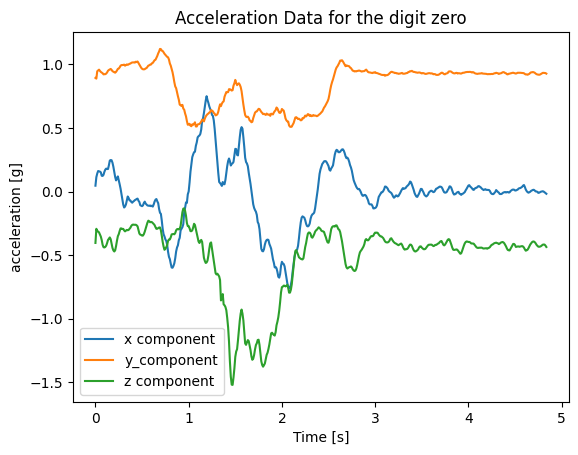

In [10]:
plot_magic_wand_data(acceleration_data,data_name="acceleration [g]",title="Acceleration Data for the digit " + stroke_type)

Plot the data array. It consists on ~ 500 acceleration vectors ax,ay,az

In [11]:
sample_frequency = 104 # Data have been sampled at 104 Hz

In [12]:
def plot_magic_wand_data(data_array,data_name=None,title=None,start_point=None):
    data_x = data_array[:,0]
    data_y = data_array[:,1]
    data_z = data_array[:,2]
    x = np.arange(0,len(data_x)*1.0/sample_frequency,1.0/sample_frequency)
    plt.plot(x,data_x,label="x component")
    plt.plot(x,data_y,label="y_component")
    plt.plot(x,data_z,label="z component")
    plt.xlabel("Time [s]")
    if data_name:
        plt.ylabel(data_name)
    plt.title(title)
    plt.legend()

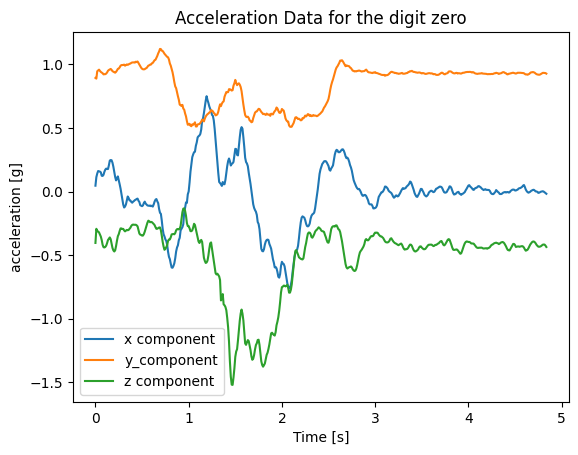

In [13]:
plot_magic_wand_data(acceleration_data,data_name="acceleration [g]",title="Acceleration Data for the digit " + stroke_type)

# Evaluate the acceleration data
Calculate and plot velocities and positions through integration

In [14]:
current_gravity  = [0.0, 0.0, 0.0]
current_gyroscope_drift = [0.0, 0.0, 0.0]
current_velocity = [0.0,0.0,0.0]
current_position = [0.0,0.0,0.0]
data_index = 0

In [15]:
def EstimateGravityDirection():
    samples_to_average = 20
    if samples_to_average >= data_index:
        samples_to_average = data_index
    #print("samples to average: {:d}".format(samples_to_average))
    start_index = data_index - samples_to_average 
    # print("Start index: {:d}".format(start_index))
    x_total = 0
    y_total = 0
    z_total = 0
    # print("Entry index: {:d}".format(start_index % data_length))
    for i in range(samples_to_average):
        index = start_index + i
        entry = acceleration_data[index]
        x_total += entry[0]
        y_total += entry[1]
        z_total += entry[2]
    gravity = [x_total/samples_to_average,y_total/samples_to_average,z_total/samples_to_average]
    return gravity

In [16]:
data_index = 1
gravity = EstimateGravityDirection()
print("Gravity: ",gravity)

Gravity:  [0.0464, 0.8941, -0.4038]


Calculate the gravity evolution

In [17]:
data_index = 1
gravity_evolution = []
for i in range(len(acceleration_data)-1):
    data_index += 1
    gravity_evolution.append(EstimateGravityDirection())
# print("Gravity evolution: ",gravity_evolution)
gravity_data = np.array(gravity_evolution)

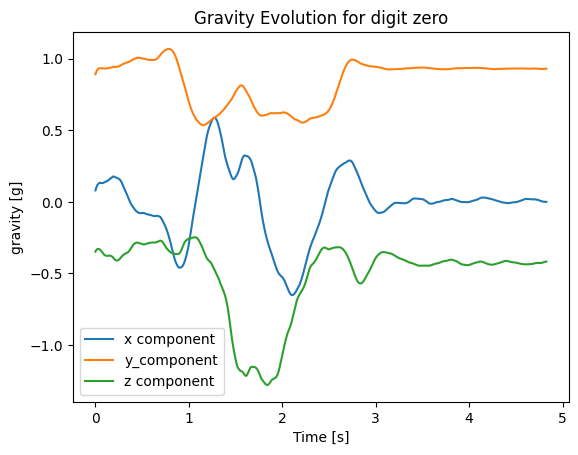

In [18]:
plot_magic_wand_data(gravity_data, data_name = "gravity [g]",title = "Gravity Evolution for digit " + stroke_type)

In [19]:
gravity = gravity_data[0]
global current_velocity,current_position
current_velocity = np.zeros(3)
current_position = np.zeros(3)

In [20]:
def UpdateVelocity(gravity):
    global current_velocity,current_position
    # print("UpdateVelocity, velocities before calc: ",velocities)
    friction_fudge = 0.98
    acc = acceleration_data[data_index]
    # print("Acceleration entry: ",acc)
    # print("Gravity: ",gravity)

    # remove the gravity from the acceleration values
    acc_minus_gravity = acc - gravity

    # print("acc minus gravity: ",ax_minus_gravity,ay_minus_gravity,az_minus_gravity)
    # update the velocity based on the normalized acceleration
    
    current_velocity += acc_minus_gravity
        
    # dampen the velocity slightly with a fudge facor to stop it exploding
    current_velocity *= friction_fudge

    # print("Current velocity: ",current_velocity)

    # update the position estimate based on the velocity
    current_position += current_velocity
    # print("UpdateVelocity, velocities after calc: ",velocities)
    return current_velocity.tolist(),current_position.tolist()

In [21]:
data_index = 0
velocities = []
positions = []
for _ in range(len(acceleration_data)-1):
    v,p = UpdateVelocity(gravity_data[data_index])
    velocities.append(v)
    positions.append(p)
    data_index += 1


Now that we have the velocity and position evolutions, let's plot it

In [22]:
velocity_data = np.array(velocities)
position_data = np.array(positions)

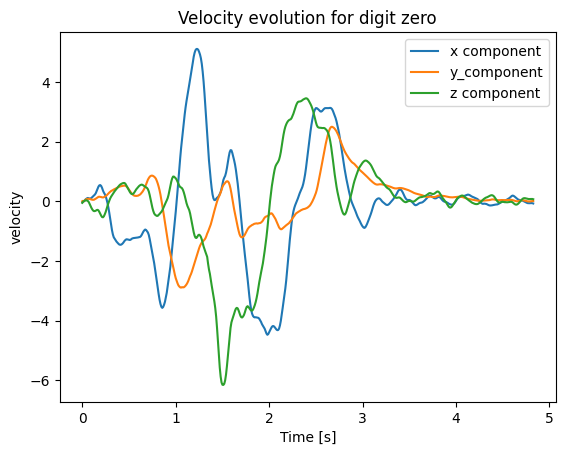

In [23]:
plot_magic_wand_data(velocity_data,data_name = "velocity", title="Velocity evolution for digit " + stroke_type)

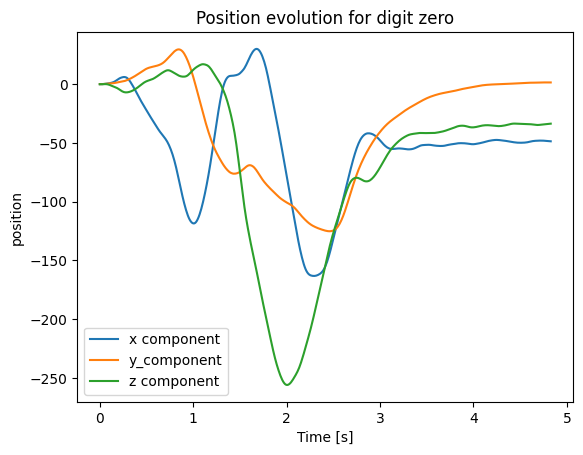

In [24]:
plot_magic_wand_data(position_data,data_name = "position", title="Position evolution for digit " + stroke_type)

In [25]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

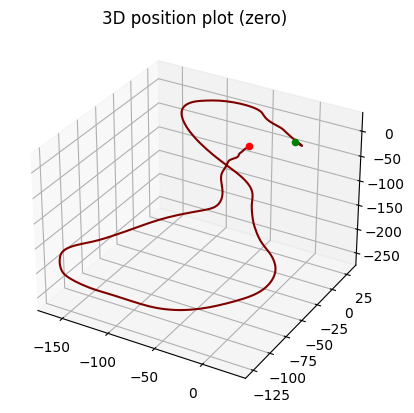

In [26]:
end = len(position_data) -1
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(position_data[:,0][0],position_data[:,1][0],position_data[:,2][0],color="green")
ax.scatter3D(position_data[:,0][end],position_data[:,1][end],position_data[:,2][end],color="red")
ax.plot3D(position_data[:,0], position_data[:,1], position_data[:,2], 'maroon')
ax.set_title('3D position plot (' + stroke_type + ')')
plt.show()

In [27]:
print("Position data at start :",position_data[0])
print("position data at end: ",position_data[end])

Position data at start : [-0.03283   0.002597 -0.054537]
position data at end:  [-48.63966263   1.43353319 -33.63400455]


# Evaluate the Gyroscope Data
Gyroscope data for several digits have been recorded. This notebook evaluates those data

In [28]:
gyroscope_data_list = []

In [29]:
f = open("gyro_" + stroke_type + "-" + series_number + ".txt","r")
gyroscope_txt = f.read().split("\n")
f.close()

In [30]:
for i in range(1,len(gyroscope_txt)):
    if gyroscope_txt[i] == "": # skip empty lines
        continue    
    gyro_xyz = gyroscope_txt[i].split(',')
    gyro = [float(gyro_xyz[0]),float(gyro_xyz[1]),float(gyro_xyz[2])]
    gyroscope_data_list.append(gyro)
for i in range(10):
    print(gyroscope_data_list[i])

[-22.4616, -57.3138, -94.2412]
[208.5635, -128.666, -25.1473]
[535.1726, -75.1366, 60.4266]
[-28.3212, 36.5612, -5.9816]
[-26.7342, 34.8521, -4.3336]
[-2.0142, 4.4557, -8.24]
[7.2024, -5.6764, -9.2776]
[7.6296, -3.9674, -8.4231]
[7.5076, -4.5167, -7.7517]
[6.9582, -6.2258, -7.0803]


In [31]:
gyroscope_data = np.array(gyroscope_data_list)

Skip the first few samples which seem to be out of bounds

In [32]:
gyroscope_data = gyroscope_data[6:]

In [33]:
print("Shape of gyroscope data: ",gyroscope_data.shape)

Shape of gyroscope data:  (498, 3)


Revert the y and z axis
This takes into account the way the accelerometer is mounted onto the magic wand

In [34]:
# gyroscope_data[:,0] = -gyroscope_data[:,0]
gyroscope_data[:,1] = -gyroscope_data[:,1]
gyroscope_data[:,2] = -gyroscope_data[:,2]

Plot the data array. It consists on ~ 500 acceleration vectors ax,ay,az

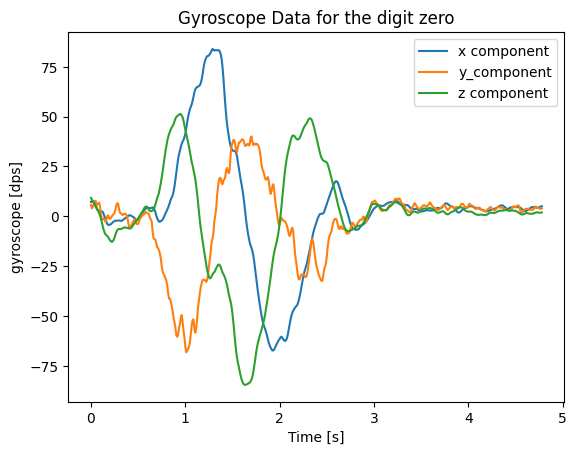

In [35]:
plot_magic_wand_data(gyroscope_data,data_name="gyroscope [dps]",title="Gyroscope Data for the digit " + stroke_type)

### Start evaluation
Estimate the gyroscope drift

In [36]:
from math import sqrt
def VectorMagnitude(vector):
    return sqrt(vector[0]*vector[0] + vector[1]*vector[1] + vector[2]*vector[2])

In [37]:
velocity_magnitude = []
for i in range(len(velocity_data)):
    velocity_magnitude.append(VectorMagnitude(velocity_data[i]))

Text(0.5, 1.0, 'Velocity magnitude')

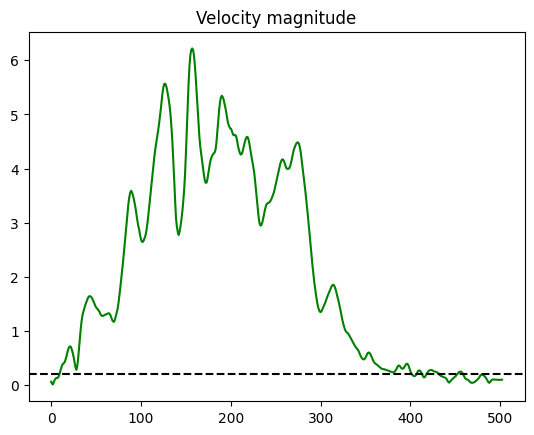

In [38]:
plt.plot(velocity_magnitude, color="green")
plt.axhline(y=0.2,color="black", linestyle="--")
plt.title("Velocity magnitude")

In [39]:
current_gyroscope_drift = np.zeros(3)

In [54]:
def EstimateGyroscopeDrift(drift):
    isMoving = VectorMagnitude(current_velocity) > 0.2
    if isMoving:
        # print("Moving at index {:d} vector magnitude: {:6.2f}".format(data_index,VectorMagnitude(current_velocity))) 
        return None
        
    samples_to_average = 20;
    if samples_to_average >= data_index:
        samples_to_average = data_index
    # print("samples to average: ",samples_to_average)
    total = np.zeros(3)
    
    for i in range(samples_to_average):
        index = data_index + i
        total += gyroscope_data[index]
    # print("total: ",total)
    drift_array = total / samples_to_average

    return drift_array.tolist()

In [55]:
drift = []
new_drift = [0.0,0.0,0.0]
data_index = 1
for i in range(1,len(gyroscope_data) -20):
    current_velocity = velocity_data[data_index]
    new_drift = EstimateGyroscopeDrift(new_drift) 
    if new_drift:
        drift.append(new_drift)
    data_index += 1

In [56]:
gyroscope_drift_data = np.array(drift) 

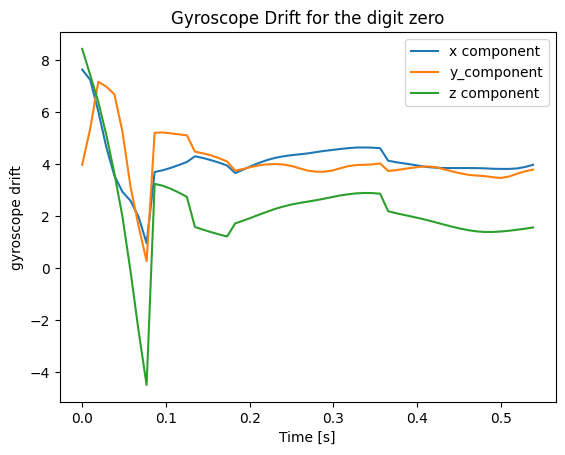

In [58]:
plot_magic_wand_data(gyroscope_drift_data,data_name="gyroscope drift",title="Gyroscope Drift for the digit " + stroke_type)

In [59]:
total = np.zeros(3)
for i in range(len(gyroscope_drift_data)):
    total += gyroscope_drift_data[i]
average_gyroscope_drift = total / len(gyroscope_drift_data)

In [60]:
print("Average gyroscope drift: ",average_gyroscope_drift)

Average gyroscope drift:  [4.10486292 4.06537263 2.22039098]


In [62]:
def UpdateOrientation():
    # print(start_index)
    recip_sample_rate = 1.0 / sample_frequency
    d = gyroscope_data[data_index]  

    # Try to remove sensor errors from the raw gyroscope_data
    d_minus_drift = d - average_gyroscope_drift

    # Convert from degrees-per-second to appropriate units for this time interval
    d_normalized = d_minus_drift * recip_sample_rate

    # Update orientation based on the gyroscope data
    previous_index = data_index -1 
    # print("previous index: {:d}".format(previous_index))
    previous_orientation = orientation_data[index]
    current_orientation = previous_orientation + d_normalized
    return current_orientation.to_list()

In [ ]:
orientation = []
data_index = 1
for i in range(len(gyroscope_data-1)):
    orientation.append(UpdateOrientation())